In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input

### Checking Dataset

In [3]:
#Importing the dataset
df = pd.read_csv("./tripadvisor_hotel_reviews.csv")


# look the data set
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

### Start Data Preprocessing

In [5]:
import re
def text_preprocessing(a):
  a = re.sub('[^a-zA-Z]',' ', a)
  a = a.lower().split()
  ps = PorterStemmer()
  clean_word = [ps.stem(i) for i in a if not i in sw]
  sen = ' '.join(clean_word)
  return sen

In [6]:
!pip install nltk

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/hafiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
sw = set(stopwords.words('english'))

In [9]:
df['clean_word']=df["Review"].apply(text_preprocessing)
df.head()

,Review,Rating,clean_word
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experi hotel monaco seattl good hote...
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


### Clean Dataset & 3 Label Class

In [10]:
df = df[['clean_word', 'Rating']]

# Ubah Rating menjadi kategori sentimen (misal: 1-2 = negatif, 3 = netral, 4-5 = positif)
def categorize_sentiment(rating):
    if rating <= 2:
        return 0  # Negatif
    elif rating == 3:
        return 1  # Netral
    else:
        return 2  # Positif

df['Sentiment'] = df['Rating'].apply(categorize_sentiment)
df.head()

,clean_word,Rating,Sentiment
0,nice hotel expens park got good deal stay hote...,4,2
1,ok noth special charg diamond member hilton de...,2,0
2,nice room experi hotel monaco seattl good hote...,3,1
3,uniqu great stay wonder time hotel monaco loca...,5,2
4,great stay great stay went seahawk game awesom...,5,2


Jumlah data per kelas Sentiment:
Negatif (0): 3214
Netral (1): 2184
Positif (2): 15093


/var/folders/47/p1nz1hvx16xb5gzw123rjhs00000gn/T/ipykernel_24367/3820776065.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


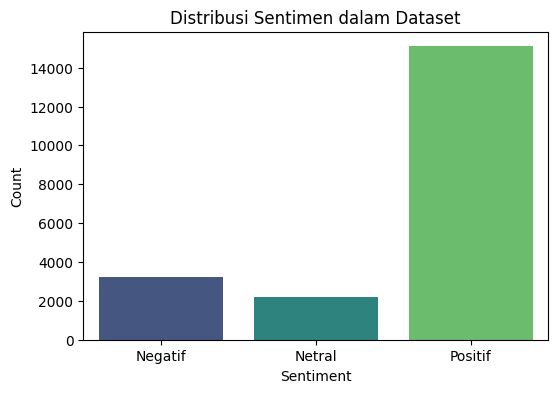

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah masing-masing Sentiment
sentiment_counts = df['Sentiment'].value_counts().sort_index()

# Cetak jumlah tiap kelas Sentiment
print("Jumlah data per kelas Sentiment:")
for sentiment, count in sentiment_counts.items():
    label = ["Negatif", "Netral", "Positif"][sentiment]  # Ubah angka ke label
    print(f"{label} ({sentiment}): {count}")

# Buat plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Tambahkan label
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xticks(ticks=[0, 1, 2], labels=["Negatif", "Netral", "Positif"])
plt.show()


In [12]:
X = df['clean_word'].values
y = df['Sentiment'].values

# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

## LSTM Model

In [13]:
model_lstm = Sequential([
    Input(shape=(100,)),
    Embedding(input_dim=5000, output_dim=64, ),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: Negatif, Netral, Positif
])

2025-04-06 11:09:13.769020: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-06 11:09:13.774453: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-06 11:09:13.774611: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-06 11:09:13.775982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 11:09:13.776016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# Compile model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model dengan dataset yang sudah di-split
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


2025-04-06 11:09:15.543846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


513/513 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7302 - loss: 0.7792 - val_accuracy: 0.7421 - val_loss: 0.7454
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.7358 - loss: 0.7573 - val_accuracy: 0.7421 - val_loss: 0.7509
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.7335 - loss: 0.7515 - val_accuracy: 0.7421 - val_loss: 0.7459
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7487 - loss: 0.7175 - val_accuracy: 0.7746 - val_loss: 0.5642
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8081 - loss: 0.5275 - val_accuracy: 0.8165 - val_loss: 0.5099
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8278 - loss: 0.4570 - val_accuracy: 0.8297 - val_loss: 0.4503
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8464 - loss: 0.4006 - val_accuracy: 0.8234 - val_loss: 0.4583
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8517 - loss: 0.3750 - val_accurac

In [17]:
from sklearn.metrics import classification_report

# Prediksi pada data uji
y_pred = model_lstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Tampilkan classification report
print(classification_report(y_test, y_pred_classes, target_names=["Negatif", "Netral", "Positif"]))

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

     Negatif       0.63      0.83      0.72       625
      Netral       0.42      0.17      0.25       432
     Positif       0.92      0.94      0.93      3042

    accuracy                           0.84      4099
   macro avg       0.66      0.65      0.63      4099
weighted avg       0.83      0.84      0.83      4099



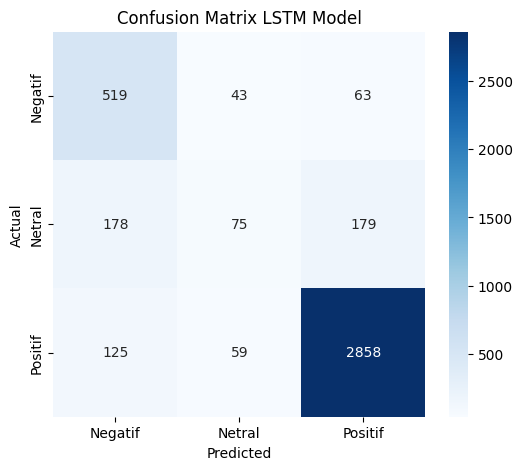

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualisasi dengan heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix LSTM Model")
plt.show()

In [20]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Model Test Accuracy: {accuracy:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8479 - loss: 0.4172
Model Test Accuracy: 0.8422
